In [29]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.lines as mlines
from matplotlib.patches import PathPatch
from matplotlib import collections

In [9]:
## Util Func
def get_latlon(reg):
    regions = {'CONUS':'24.74 49.34 -124.78 -66.95',\
              'NA':'15 72 -167 -50',\
              'EUS':'24.74 49.34 -97 -66.95',\
              'ECN':'18 45 90 130',\
              'IND':'6 40 66 98',\
              'CAF':'-5 20 -18 50', \
              'SH_pole':'-90 -60 -180 180',\
              'SH_midlat':'-60 -30 -180 180',\
              'Tropics':'-30 30 -180 180',\
              'NH_midlat':'30 60 -180 180',\
              'NH':'0 90 -180 180',\
              'SH':'-90 0 -180 180',\
              'NH_pole':'60 90 -180 180',\
              'Global':'-90 90 -180 180',\
              'CUS':'31 41 -104 -91',\
              'ENA':'32 46 -33 -21',\
              'NEP':'30 50 -160 -120',\
              'SO':'-60 -40 130 165'}
    lat1 = float(regions[reg].split(' ')[0])
    lat2 = float(regions[reg].split(' ')[1])
    lon1 = float(regions[reg].split(' ')[2])
    lon2 = float(regions[reg].split(' ')[3])
    return lat1,lat2,lon1,lon2


In [21]:
climo_dir = '/global/cfs/projectdirs/e3sm/hass877/clim_out/'

eam_data = xr.open_dataset(climo_dir + 'SSA_Control_PD_ANN_201601_201612_climo.nc')
eam_lon = eam_data['lon'].values
eam_lon[eam_lon > 180.] -= 360.
eam_lat = eam_data['lat'].values

eamxx_data = xr.open_dataset(climo_dir + 'ne256pg2_eamxx_pd_ANN_201901_202012_climo.nc')
eamxx_lon = eam_data['lon'].values
eamxx_lon[eamxx_lon > 180.] -= 360.
eamxx_lat = eamxx_data['lat'].values

In [24]:
aer_sfc_eam = eam_data['bc_a4'][-1,:]
aer_sfc_eamxx = eamxx_data['bc_a4'][-1,:]

In [25]:
reg = 'NA'
lat1, lat2, lon1, lon2 = get_latlon(reg)

lon = eam_lon.copy()
lat = eam_lat.copy()
aer_sfc_eam_latlon = aer_sfc_eam.where((lon>=lon1) & (lon<=lon2))
aer_sfc_eam_latlon = aer_sfc_eam_latlon.where((lat>=lat1) & (lat<=lat2))

lon = eamxx_lon.copy()
lat = eamxx_lat.copy()
aer_sfc_eamxx_latlon = aer_sfc_eamxx.where((lon>=lon1) & (lon<=lon2))
aer_sfc_eamxx_latlon = aer_sfc_eamxx_latlon.where((lat>=lat1) & (lat<=lat2))

In [23]:
aer_sfc_eam_latlon

<xarray.DataArray 'bc_a4' (ncol: 21600)> Size: 173kB
array([nan, nan, nan, ..., nan, nan, nan], shape=(21600,))
Coordinates:
    lev      float64 8B 998.5
    time     int64 8B ...
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/kg
    mixing_ratio:  dry
    long_name:     bc_a4 concentration
    cell_methods:  time: mean

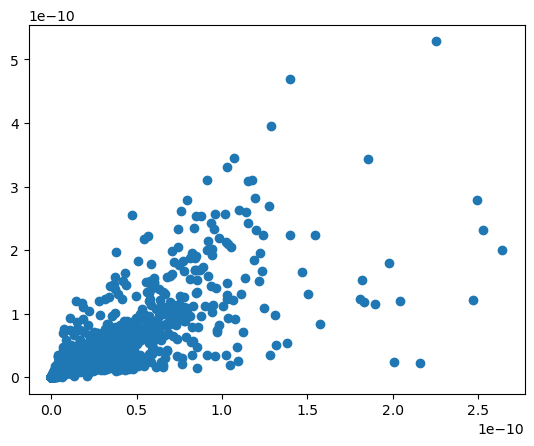

In [28]:
plt.scatter(aer_sfc_eam_latlon,aer_sfc_eamxx_latlon)
#corr=stats.spearmanr(aer_sfc_eam_latlon,aer_sfc_eam_latlon)
xy = np.vstack([df_nona[typ],df_nona[var]])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
improve_obs, mod, z_mod = df_nona[typ][idx], df_nona[var][idx], z[idx]
heatmap = ax.scatter(improve_obs, mod, c='k', s=size, edgecolor='k',vmax=maxv, vmin=0,zorder=2)

0.9634718260455115 49.78397372258276


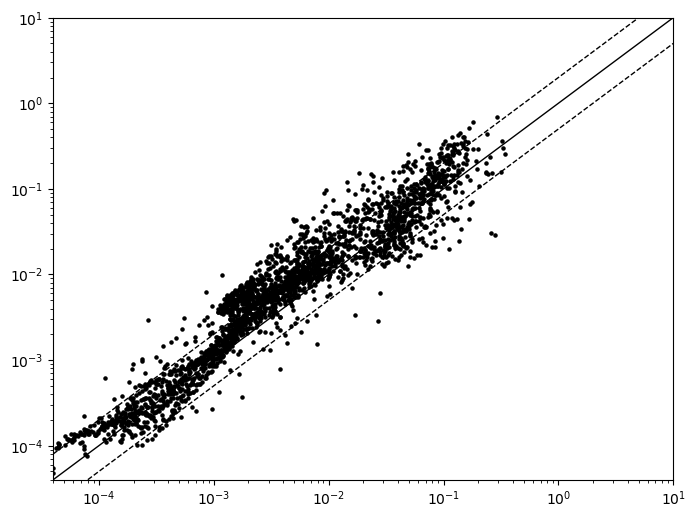

In [55]:
factaa = 1.01325e5 / 8.31446261815324 / 273.15 * 28.9647 / 1.e9   # kg-air/cm3-air
factbb = factaa * 1.e15

# Flatten the arrays if they are multi-dimensional, or ensure they are 1D
x = aer_sfc_eam_latlon.values.flatten() * factbb
y = aer_sfc_eamxx_latlon.values.flatten() * factbb

# Mask to remove NaNs (only keep values where both x and y are not NaN)
mask = ~np.isnan(x) & ~np.isnan(y)

# Apply the mask
x_clean = x[mask]
y_clean = y[mask]

# Now compute Spearman correlation
rho, pval = stats.spearmanr(x_clean, y_clean)
meanB = abs(((y_clean - x_clean).sum()/x_clean.sum())*100)

xy = np.vstack([x_clean,y_clean])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
improve_obs, mod, z_mod = x_clean[idx], y_clean[idx], z[idx]

plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
ax.scatter(improve_obs, mod, c='k', s=5, edgecolor='k')
ax.set_yscale('log')
ax.set_xscale('log')

xx1=4e-5 # BC
yy1=4e-5 # BC
xx2=1e1
yy2=1e1 # BC
plt.xlim([xx1,xx2]) # BC
plt.ylim([yy1,yy2]) #BC
###########
x1 = mlines.Line2D([xx1, xx2], [yy1, yy2], color='k', linestyle='-',linewidth=1)
ax.add_line(x1)
x1 = mlines.Line2D([2*xx1, xx2], [yy1, 0.5*yy2], color='k', linestyle='--',linewidth=1)
ax.add_line(x1)
x1 = mlines.Line2D([xx1, 0.5*xx2], [2*yy1, yy2], color='k', linestyle='--',linewidth=1)
ax.add_line(x1)

print(rho, meanB)